# Computing absorption spectra with TD-CIS

Please see the documentation/excercises located [here](https://gitlab.com/hylleraasplatform/learning/-/blob/master/HylleraasSchool2024/electron_dynamics/tutorials/tutorials.md?ref_type=heads).


In [4]:
# Various imports

import numpy as np
from matplotlib import pyplot as plt
plt.style.use('classic')
from tqdm.notebook import tqdm
from scipy.integrate import complex_ode
from scipy.signal import find_peaks
import basis_set_exchange as bse
from quantum_systems import construct_pyscf_system_rhf
from quantum_systems.time_evolution_operators import DipoleFieldInteraction
from ci_singles import CIS, TDCIS
from numpy.fft import fft, fftfreq, fftshift

from fft_tdse.simulator import LaserPulse
from copy import copy

pyscf_geometries = dict(
    he="he 0.0 0.0 0.0",
    be="be 0.0 0.0 0.0",
    ne="ne 0.0 0.0 0.0",
    h2="h 0.0 0.0 0.0; h 0.0 0.0 1.4",
    lih="li 0.0 0.0 0.0; h 0.0 0.0 3.08",
    bh="b 0.0 0.0 0.0; h 0.0 0.0 2.3289",
    chp="c 0.0 0.0 0.0; h 0.0 0.0 2.137130",
    h2o="O 0.0 0.0 -0.1239093563; H 0.0 1.4299372840 0.9832657567; H 0.0 -1.4299372840 0.9832657567",
    no2="N; O 1 3.25; O 1 3.25 2 160",
    lif="f 0.0 0.0 0.0; li 0.0 0.0 -2.9552746891",
    co="c 0.0 0.0 0.0; o 0.0 0.0 2.1316109151",
    n2="n 0.0 0.0 0.0; n 0.0 0.0 2.074",
    co2="c 0.0 0.0 0.0; o 0.0 0.0 2.1958615987; o 0.0 0.0 -2.1958615987",
    nh3="N 0.0 0.0 0.2010; H 0.0 1.7641 -0.4690; H 1.5277 -0.8820 -0.4690; H -1.5277 -0.8820 -0.4690",
hf="h 0.0 0.0 0.0; f 0.0 0.0 1.7328795",
ch4="c 0.0 0.0 0.0; h 1.2005 1.2005 1.2005; h -1.2005 -1.2005 1.2005; h -1.2005 1.2005 -1.2005; h 1.2005 -1.2005 -1.2005",
)

In [5]:
# Choose molecular geometry and basis set.

# molecule = "h 0.0 0.0 -0.7; h 0.0 0.0 0.7"
# #molecule = "li 0.0 0.0 0.0; h 0.0 0.0 3.05"
# basis = "aug-cc-pvdz"
# charge = 0
# name = 'lih'

# water in equilibrium
#molecule = "o 0.0 0.0 0.0; h 0.0 0.0 0.95; h 0.0 0.95 0.0"
basis = "aug-cc-pvdz"
charge = 0
name = 'h2'
molecule = pyscf_geometries[name]

# Get basis set.
basis_set = bse.get_basis(basis, fmt="nwchem")

# Do Hartree-Fock and change integrals to MO-basis.
system0 = construct_pyscf_system_rhf(
    molecule=molecule,
    basis=basis_set,
    add_spin=False,
    charge=charge,
    cart=False,
    anti_symmetrize=False,
)

# Compute the (field-free) CIS eigenstates.
# This is the starting point for the TDCIS calculation.
cis = CIS(system0).compute_eigenstates()
eps, C = cis.eps, cis.C

print(f'CIS Hilbert space is {C.shape[0]}-dimensional.')
print(f'Computed {len(eps)} eigenstates.')

# Get the ground state.
C_ground_state = C[:, 0]

# Helper function to print a CI wavefunction.
def print_state(C, newline_every = 4):
    """Prints a CI wavefunction.
    
    Args:
        C (np.ndarray): CI coefficients.
        newline_every (int): How many components to print before inserting a newline.
    
    """
    print('|Psi> = ', end='')
    for k in range(len(C)):
        print (f'({C[k]:.6f})|{k}> ', end='')
        if k % newline_every == newline_every-1:
            print('')
        if k < len(C)-1:
            print('+ ', end='')
    print('')

print_state(C_ground_state)


converged SCF energy = -1.12878775317463
CIS Hilbert space is 18-dimensional.
Computed 18 eigenstates.
|Psi> = (-1.000000)|0> + (0.000000)|1> + (0.000000)|2> + (-0.000000)|3> 
+ (-0.000000)|4> + (0.000000)|5> + (-0.000000)|6> + (-0.000000)|7> 
+ (0.000000)|8> + (-0.000000)|9> + (0.000000)|10> + (0.000000)|11> 
+ (0.000000)|12> + (0.000000)|13> + (-0.000000)|14> + (-0.000000)|15> 
+ (0.000000)|16> + (0.000000)|17> 


In [6]:
# Time integration parameters
dt = 2e-2
t_final = 2000
 
# Set up time grid and laser pulse
n_steps = int(t_final / dt)
t_grid = np.linspace(0, t_final, n_steps + 1)
dt = t_grid[1] - t_grid[0]
print(f'Adjusted time step: {dt}')
print(f"number of time steps: {n_steps}")

# Set up delta pulse kick
pulse = LaserPulse(
    E0=0.001/dt, omega=0.0, T=dt, t0=0.0, envelope='trap', N = np.inf
)



Adjusted time step: 0.02
number of time steps: 100000


In [7]:


# Set up dipole moment histories
# After the calculation, dip_hist[k,alpha] will contain the
# dipole moment in polarization direction alpha after k time steps.
dip_hist = np.zeros((n_steps+1, 3), dtype=np.float64)

# Loop over polarization directions
for alpha in range(3):
    
    # Set up system Hamiltonian
    system = copy(system0)
    polarization = [1 if beta==alpha else 0 for beta in range(3)]
    
    system.set_time_evolution_operator(
        DipoleFieldInteraction(pulse, polarization_vector=polarization)
    )
    
    # Set integrator and initial state
    tdcis = TDCIS(system)
    integrator = complex_ode(tdcis).set_integrator("vode")


    # integrator = complex_ode(tdcis).set_integrator(
    #     "GaussIntegrator", s=3, eps=1e-10
    # )
    Ct = np.complex128(C_ground_state)
    integrator.set_initial_value(Ct)

    # Compute density matrix for t = 0
    rho_t = tdcis.compute_one_body_density_matrix(t_grid[0], Ct)

    # Compute dipole moment along polarization direction for t=0
    dip_hist[0, alpha] = tdcis.compute_one_body_expectation_value(
        rho_t, system.dipole_moment[alpha]
    ).real

    # Do time integration
    for i in tqdm(range(n_steps)):
        Ct = integrator.integrate(integrator.t + dt)

        # Compute density matrix for t = t_grid[i+1]
        rho_t = tdcis.compute_one_body_density_matrix(t_grid[i + 1], Ct)

        # Compute dipole moment along polarization direction for t=t_grid[i+1]
        dip_hist[i + 1, alpha] = tdcis.compute_one_body_expectation_value(
            rho_t, system.dipole_moment[alpha]
        ).real


    


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

In [10]:
# Print the final wavefunction of the final integration, just 
# out of curiosity
print_state(Ct)

|Psi> = (-0.999999-0.000000j)|0> + (-0.000158-0.000871j)|1> + (0.000001-0.000000j)|2> + (-0.000921-0.000183j)|3> 
+ (-0.000000-0.000000j)|4> + (0.000000+0.000000j)|5> + (-0.000000-0.000001j)|6> + (-0.000000-0.000000j)|7> 
+ (0.000000-0.000000j)|8> + (0.000557+0.000113j)|9> + (-0.000000+0.000000j)|10> + (-0.000252+0.000053j)|11> 
+ (-0.000000+0.000000j)|12> + (0.000000+0.000000j)|13> + (0.000000-0.000000j)|14> + (-0.000000-0.000000j)|15> 
+ (0.000000+0.000000j)|16> + (-0.000019+0.000004j)|17> 


Estimated spectral points:  [12.73758302 15.72963272 16.24255552 24.36383329 40.17895314 48.3002309 ]


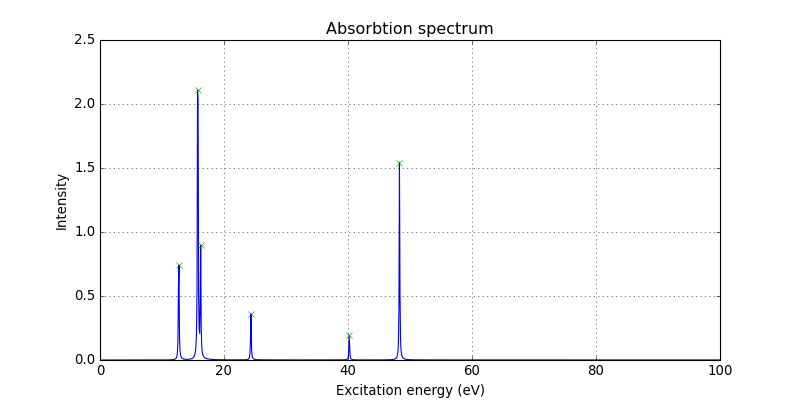

In [11]:

# Compute FFT of dipole moment
eV = 27.2114
# Get FFT frequency grid
om =  eV*fftshift(fftfreq(n_steps, dt) * 2 * np.pi)
max_freq = 100

# damping factor to broaden peaks
damping = np.exp(-0.002*t_grid[1:])
# induced dipole moments along each polarization direction
dip_ind0 = dip_hist[1:,0] - dip_hist[0,0]
dip_ind1 = dip_hist[1:,1] - dip_hist[0,1]
dip_ind2 = dip_hist[1:,2] - dip_hist[0,2]

# total signal
signal = damping*(dip_ind0 + dip_ind1 + dip_ind2)

# select range of frequencies 0 < freq < max_freq
filter = np.where((om > 0) & (om < max_freq))

# Compute S(omega)
signal_fft = fftshift(fft(signal, norm='ortho'))
S = np.abs(om*signal_fft.imag)

# Estimate peaks in spectrum
peaks, _ = find_peaks(S[filter], height=0.01, prominence=0.01)
print('Estimated spectral points: ', om[filter][peaks])

# Plotting
%matplotlib widget
plt.figure(figsize=(10,5))
plt.plot(om[filter], S[filter])
plt.plot(om[filter][peaks], S[filter][peaks], "x")



plt.xlabel('Excitation energy (eV)')
plt.ylabel('Intensity')
plt.title('Absorbtion spectrum')
plt.grid('on')
plt.savefig(name + '_spectrum.pdf')
plt.show()